<a href="https://colab.research.google.com/github/gus474/ML-for-Biosystems-Engineering-III-/blob/main/Machine_Learning_for_Biosystems_Engineering_Supervised_Learning_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The purpose of this report is to develop an ML model that can differentiate between two similar looking varieties of apple -- *Crimson Snow* and *Pink Lady*. Specifically, we will utilize Principal Components Regression (PCR) to predict apple variety based on an image.

Let's approach the task in the following format:

```
data
  | - train
        | - Apple Crimson Snow
            | - img 1
            | - img 2
            | - ...
            | - img i
        | - Apple Pink Lady
            | - img 1
            | - img 2
            | - ...
            | - img j
  | - test
        | - Apple Crimson Snow
            | - img 1
            | - img 2
            | - ...
            | - img m
        | - Apple Pink Lady
            | - img 1
            | - img 2
            | - ...
            | - img n
```

#### Loading the train image + label dataset

Here I've iteratively loaded all train and test images into two Numpy arrays called `img_train_arr` and `img_test_arr` of shape `[n_images, width, height, c_channels]`. I created two Numpy arrays called `y_train` and `y_test` of shape `[n_images,]` which contain a `1` if the image an Pink Lady variety and a `0` if it is a Crimson Snow variety.
- I used the `skimage.io.imread()` function to load the images
- I've used the `os` library with the `os.listdir()` function to create a list of files for iterating through within a loop
- Note (if your attempting): This could take ~5 minutes to load all the images.

In [ ]:
import os

#Creating directories to find training and testing data.
traindir = '/content/drive/MyDrive/Data Compression and Machine Learning/data/train'
testdir = '/content/drive/MyDrive/Data Compression and Machine Learning/data/test'

img_train_arr = [] #Empty lists
img_test_arr = []
y_train = []
y_test = []

In [ ]:
from skimage.io import imread
import matplotlib as plt
import numpy as np

for i in os.listdir(traindir): #Assorting training data by apple type.
  if i == 'Apple Pink Lady':
    for j in os.listdir(traindir + '/' + i):
      y_train.append(1) #Creating a binary vector for y_train
      img_train_arr.append(imread(traindir + '/' + i + '/' + j))#loading images into our training array
  if i == 'Apple Crimson Snow':
    for j in os.listdir(traindir + '/' + i):
      y_train.append(0)
      img_train_arr.append(imread(traindir + '/' + i + '/' + j))
for i in os.listdir(testdir):
  if i == 'Apple Pink Lady':
    for j in os.listdir(testdir + '/' + i):
      y_test.append(1)
      img_test_arr.append(imread(testdir + '/' + i + '/' + j))
  if i == 'Apple Crimson Snow':
    for j in os.listdir(testdir + '/' + i):
      y_test.append(0)
      img_test_arr.append(imread(testdir + '/' + i + '/' + j))





#x = imread('/content/drive/MyDrive/Data Compression and Machine Learning/data/train')

#### Formulating the Principal Components score matrix using Singular Value Decomposition (SVD)

For the training set, I used SVD to decompose $\textbf{X}_{train}$ into its Principal Component Score matrix ($\textbf{Z}_{train}$) and Loading matrix ($\textbf{V}_{train}^T$). Ultimately, I utilize $\textbf{Z}_{train}$ to fit a linear regression model based on the following equation:

<br>
<center>
$\textbf{y} = \textbf{Z}_{train}\textbf{w}$
</center>
</br>

where $\textbf{y}$ is a 1D matrix of 0's and 1's defining if an apple is a Pink Lady or Crimson Snow variety (`y_train` above); $\textbf{w}$ is a 1D matrix the fitted weights (i.e. coefficients) for each of the principal components in $\textbf{Z}_{train}$. The shape of $\textbf{y}$ is equal to `[number of images in the training set x 1]`. I'm assuming the shape of $\textbf{w}$ is equal to the `[number of principal components x 1]`:


In [ ]:
import numpy as np
#from numpy.linalg import svd

y_train = np.array(y_train)
y_test = np.array(y_test)
img_test_arr = np.array(img_test_arr)
img_train_arr = np.array(img_train_arr)
#nimg_train_arr

**What is the shape of $\textbf{Z}_{train}$ & what does each of the axes correspond with (here specifically)?**

- *Z_train is the dot product of U and Sigma, thus it will have m rows, and r columns. Since there are 900 pictures in the training data, Z_train will have m = 900 rows.
Since sigma takes the axis with lesser elements (dimensional reduction), and U has 30,000 elements in it's columns, Z will be a square matrix with r = 900 columns.
Z's square form of m = 900 and r = 900 comes from U_train having 900 samples and S_train taking the axis with lesser values (between 900 & 30k, which of course is 900).
Thus Z_train has m from U_train and r from sigma. Z_train is also referred to as the Principle Component Score and essentially evaluates the relevancy of each principle component in catagorizing different apple types (as per below).*

In [ ]:
img_train_arr.shape



(900, 100, 100, 3)

#### Formulating $\textbf{X}_{train}$ for Principal Components Regression

Recall from linear algebra, that SVD states that any positive real matrix $\textbf{X}$ can be decomposed into the product of three matrices,

<br>
<center>
$\textbf{X} = \textbf{U} \Sigma \textbf{V}^T$
</center>
</br>

and that the Principal Components formulation can be derived by simply taking the dot product of $\textbf{U} \Sigma$ which equals $\textbf{Z}$, such that,

<br>
<center>
$\textbf{X} = \textbf{Z} \textbf{V}^T$
</center>
</br>

Assuming that $\textbf{V}^T$ has a shape equal to the `[number of principal components x (image width x image height x number of color channels)]`:

- *X consists of the number of y values by all the other components of the sample size, and in this case it has 900 by 30,000 elements.*
- *M refers to the rows and n refers to the columns. Since X is the product of Z_train and V_T_Train, we know that X will have the m of Z_train which is 900, and the n of V_T_train.T (r by n) where n refers to the (length) * (width) * (channels) of each Image.  Hence X has m = 900 and n = 30k.*

#### Reshaping $\textbf{X}_{train}$ to obtain desired dimensions
- I reshaped `img_train_arr` so that it has the same shape as I derived for $\textbf{X}_{train}$ above.

*The rows in X_train correspond to the number of samples (of images) we have in the training dataset. The columns refer to each compononent within each picture (width * length * color).*

In [ ]:
n_images, width, height, c_channels = img_train_arr.shape
X_train = img_train_arr.reshape(n_images, width*height*c_channels)
#The rows in X_train correspond to the number of samples (of images) we have in the training dataset. The columns refer to each compononent within each picture (width*length*color).
X_train.shape #number of pictures by


(900, 30000)

#### 1.e. Mean centering columns in $\textbf{X}_{train}$ to obtain $\textbf{X}_{c, train}$ and assigning this variable to the name `X_c_train`.

In [ ]:
X_c_train = X_train - X_train.mean(axis=0)
X_c_train.mean(axis = 0)


array([ 5.93697930e-15, -3.91587997e-15,  1.11160464e-14, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

#### Performing SVD and generate principle components matrices
- Using Numpy, I perform SVD on $\textbf{X}_{c, train}$, and assign the output to the variables `U_train`, `S_train`, and `V_T_train`. I then calculate $\textbf{Z}_{train}$ from this output and assign it to the variable name `Z_train`.
- Note if your attempting yourself: Use `full_matrices=False` in your svd function, which runs the compact, as opposed to full, SVD.

In [ ]:
from numpy.linalg import svd #Calling in svd function
U_train, S_train, V_T_train = svd(X_c_train, full_matrices = False)

In [ ]:
Z_train = U_train.dot(np.diag(S_train)) #Z_train is the dot product of U_train and S_train
Z_train.shape

(900, 900)

#### I've plotted the cumulative energy of each principal component based on the strength matrix, `S_train`.
- *We can see the cumulativie sum of S_train on subsequent additions of PCA components into the model, and how accurately they describe the original dataset.*

In [ ]:
import plotly.express as px
fig = px.line(x = range(0, S_train.shape[0]),
              y = S_train.cumsum()/S_train.sum(),
              labels = dict(x='No. Principal Components', y='energy'))
fig.show()
#Here we can see the cumulativie sum of S_train on subsequent additions of PCA components into the model, and how accurately they describe the original dataset.

- *We can see at different energy levels by importance level. To describe 90% of our oiriginal data, we would need 535 principle components. With only one principle component (k = 1) out of the 900, we can describe more than 6% of our original data!*

In [ ]:
import numpy as np
np.argwhere(S_train.cumsum()/S_train.sum() > 0.90)[0]
S_train.cumsum()/S_train.sum()
#Here we can see at different energy levels by importance level. To describe 90% of our oiriginal data, we would need 535 principle components.
#With only one principle component (k = 1) out of the 900, we can describe more than 6% of our original data.

array([0.0603534 , 0.10302245, 0.13037826, 0.15652119, 0.17850168,
       0.19727619, 0.21468896, 0.23115996, 0.24594573, 0.26068204,
       0.27347978, 0.2851644 , 0.2962238 , 0.30668217, 0.31696647,
       0.32619421, 0.33488814, 0.34347787, 0.35152988, 0.35918929,
       0.36646816, 0.37347178, 0.3802652 , 0.38677378, 0.39306038,
       0.39892385, 0.4046667 , 0.41010637, 0.41545176, 0.42064419,
       0.42581687, 0.43065785, 0.43531397, 0.43993212, 0.44434858,
       0.44867157, 0.45291303, 0.45704838, 0.46111455, 0.46514569,
       0.46904569, 0.47283674, 0.47653296, 0.48020014, 0.48379543,
       0.48729458, 0.49068279, 0.49395369, 0.49721857, 0.50040791,
       0.50351546, 0.50659397, 0.50961454, 0.51261324, 0.51552519,
       0.51838629, 0.52121048, 0.52394184, 0.52661297, 0.52923048,
       0.5318249 , 0.53439369, 0.53690429, 0.5393706 , 0.54178692,
       0.54417841, 0.54655837, 0.548905  , 0.55124119, 0.5535261 ,
       0.55572972, 0.55791431, 0.56008651, 0.5622255 , 0.56432

#### Visually examining how truncating the number of principal components in $\textbf{Z}_{train}$ to `k` columns affects the reconstructed image, $\textbf{X}_{train,k}$, versus original image, $\textbf{X}_{train}$.

In other words, I calculate the following equation:

<br>
<center>
$\textbf{X}_{train,k} = \textbf{Z}_{train,k} \textbf{V}^T_{train,k}$
</center>
</br>

- I plot the original image along with reconstructed images with $k$ equal to 1, 5, 25, 100, 450, and 900 for images with index, $m$, of `50` and `600`.

- *We can see that the models of k < or = 25, the image tends to be fuzzier around the edges, and a black edge of color tends to be very visible like a ring around the image. When 900 > k >= 100, the image gains a visible texture and the ring dissipates into a few pixels of color around the edges. At k = 900, we obviously have the original images.**

(*Notes for plotting as an RGB image if you're attempting*):
- Remember to reshape the image back to its original dimensions.
- Shift the image back to its orginal RGB values by reversing the mean centering operation performed earlier
- Convert your resulting $\textbf{X}_{train,k}$ to 8-bit unsigned integer using the `.astype(np.uint8)` method.
- I included a unique title for each plot.

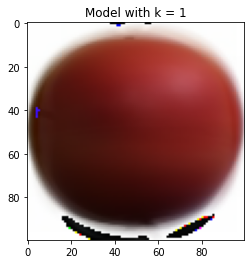

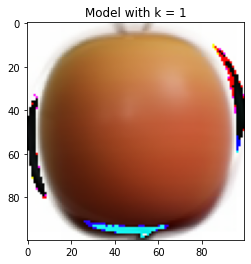

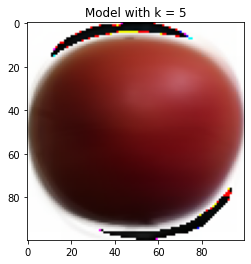

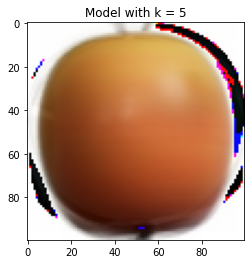

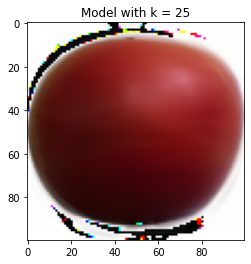

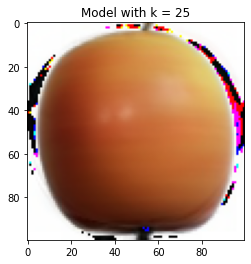

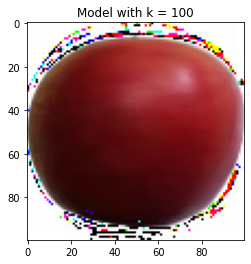

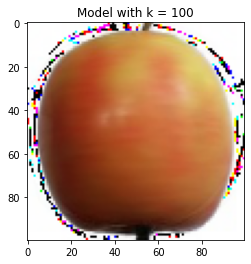

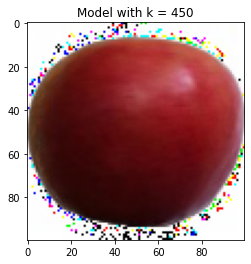

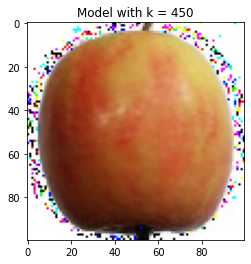

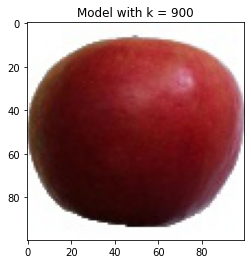

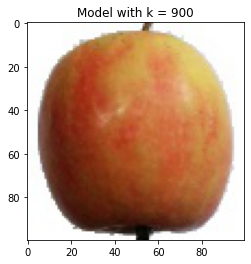

In [ ]:
import matplotlib.pyplot as plt

for k in [1,5,25,100,450,900]: #Different numbers of components
  for m in [50,600]: #Different pictures
    X_train_img = Z_train[:,:k].dot(V_T_train[:k,:])
    X_train_img = X_train_img + X_train.mean(axis=0)
    X_train_imgF = X_train_img.astype(np.uint8).reshape(n_images, width, height, c_channels)[m]
    #plt.imshow(img_train_arr[m])
    plt.imshow(X_train_imgF)
    plt.title('Model with k = ' + str(k))
    plt.show()
#We can see that the models of k < or = 25, the image tends to be fuzzier around the edges, and a black edge of color tends to be very visible like a ring around the image.
#When 900 > k >= 100, the image gains a visible texture and the ring dissipates into a few pixels of color around the edges. At k = 900, we obviously have the original images.

#### Training a linear model to predict $\textbf{y}_{train}$ using $\textbf{Z}_{train,k}$

I use the equation provided above,

<br>
<center>
$\textbf{y}_{train} = \textbf{Z}_{train,k} \textbf{w}$
</center>
</br>

to train five models in which k = 1, 5, 25, 100, and 500; that is the first 1, 5, 25, 100, and 500 principal components are included in each model respectively.

For each model I've:
- Created a scatterplot of observed values of $\textbf{y}_{train}$ (x-axis) versus predicted values, $\hat{\textbf{y}}_{train}$ (y-axis).
- Calculated a final prediction for each apple by assuming that any predicted value greater than `0.5` is a `1` (i.e. a Pink Lady variety) and any predicted value less than or equal to `0.5` is a `0` (i.e. a Crimson Snow variety).
- Calculated the training prediction accuracy as the number of correct predictions divided by the total number of predictions.

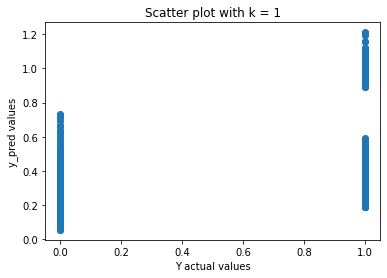


 With k = 1, our prediction accuracy is 0.7455555555555555




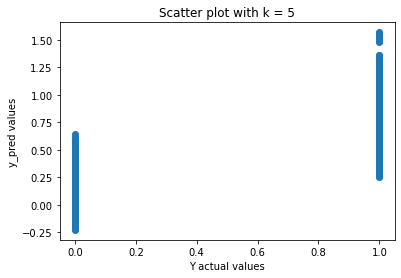


 With k = 5, our prediction accuracy is 0.9488888888888889




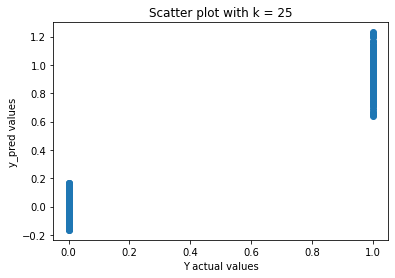


 With k = 25, our prediction accuracy is 1.0




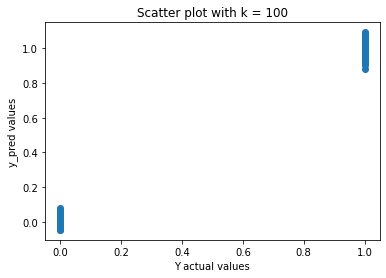


 With k = 100, our prediction accuracy is 1.0




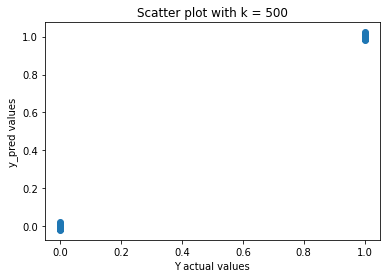


 With k = 500, our prediction accuracy is 1.0




In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

for k in [1,5,25,100,500]:
  X = Z_train[:,0:k]
  y = y_train
  lm = LinearRegression()
  lm.fit(X,y)
  y_pred = lm.predict(X)
  plt.scatter(x = y_train,y =  y_pred)
  plt.xlabel('Y actual values')
  plt.ylabel('y_pred values')
  plt.title("Scatter plot with k = " + str(k))
  plt.show()
  prediction_list = []

  for i in y_pred:

    if i > 0.5:
      prediction_list.append(1)
    else:
      prediction_list.append(0)
  nprediction_list = np.array(prediction_list)
  TF = nprediction_list == y_train
  accuracy = len(TF[TF == True])/len(TF)
  print("\n With k = " + str(k) + ", our prediction accuracy is " + str(accuracy) + "\n\n")



#### Evaluating the linear model trained above by predicting $\textbf{y}_{test}$ using $\textbf{Z}_{test,k}$

Note if you attempt: You'll need to project $\textbf{X}_{c,test}$ into the principal component space of $\textbf{V}^T_{train}$ using the equation:

<br>
<center>
$\textbf{Z}_{test,k} = \textbf{X}_{test,k} \textbf{V}_{train,k} $
</center>
</br>

Because $\textbf{V}_{train,k}$ is an orthogonal matrix, it's inverse is equal to its transpose.

Again, I've trained five models in which k = 1, 5, 25, 100, and 500.

In [ ]:

n,w,l,c = img_test_arr.shape #converting the testing images into the format of our X

X_test = img_test_arr.reshape(n,w*l*c)

X_test.shape


(300, 30000)

In [ ]:
X_c_test = X_test - X_test.mean(axis = 0)
X_c_test.mean(axis = 0)

Z_test = (X_c_test).dot(V_T_train.T) #Using our V_T_train.T to convert our Z_test into our Principle Component Score for testing.


array([[ 2.83036149e-05, -4.41928424e-05,  1.54734164e-04, ...,
        -2.57688714e-04,  5.95266715e-04, -1.49153304e-01],
       [ 1.27613360e-05, -3.91956555e-05,  3.83305922e-06, ...,
        -4.19770114e-04,  6.73460063e-05,  1.31327634e-02],
       [ 3.50955206e-05, -2.43686307e-04,  9.10794530e-05, ...,
         5.39481658e-04,  7.24262199e-05,  3.83819296e-02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

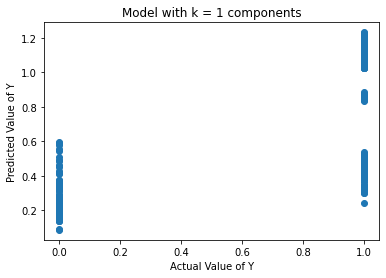


 The accuracy of the k = 1 model is 0.8033333333333333




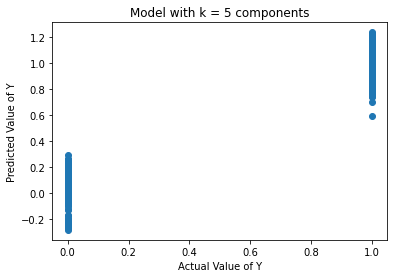


 The accuracy of the k = 5 model is 1.0




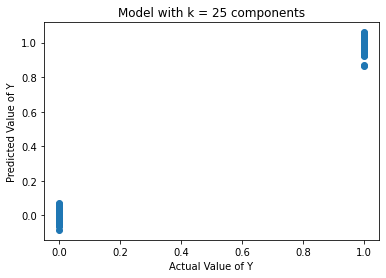


 The accuracy of the k = 25 model is 1.0




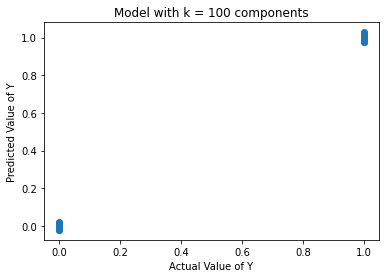


 The accuracy of the k = 100 model is 1.0




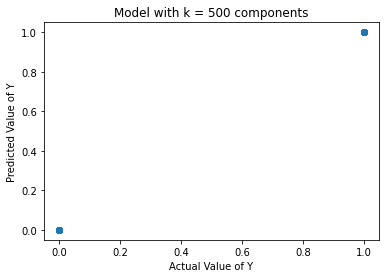


 The accuracy of the k = 500 model is 1.0




In [ ]:
for k in [1, 5, 25, 100, 500]: #Running a for loop through different number of principle components
  X = Z_test[:,:k]
  y = y_test
  lm = LinearRegression()
  lm.fit(X,y)
  ytest_pred = lm.predict(X)
  plt.scatter(x = y_test, y =  ytest_pred)
  plt.xlabel("Actual Value of Y")
  plt.ylabel("Predicted Value of Y")
  plt.title('Model with k = ' + str(k) + ' components')
  plt.show()
  accuracy_list = []
  for i in  ytest_pred:
    if i > 0.5:
      accuracy_list.append(1)
    else:
      accuracy_list.append(0)
  TF = np.array(accuracy_list) == y_test
  accuracy = len(TF[TF == True])/len(TF)
  print('\n The accuracy of the k = ' + str(k) + ' model is ' + str(accuracy) + '\n\n')